In [ ]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [ ]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [ ]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [8]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [10]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [11]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [12]:
def get_num_countries_clean(num):
    if num is None or pd.isna(num):
      return None
    if num >= 10:
      return 10
    return num
df_annotations["num_countries_clean"] = df_annotations["num_countries"].apply(get_num_countries_clean)

# Train and evaluate the number of countries extractor

In [13]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.num_countries_clean.isna())]

In [14]:
df_val = df_annotations[df_annotations.train_val == "val"]

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [19]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [ ]:
model.fit(df_train.text, df_train.num_countries_clean)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['taient', 'tais', 'tait', 'tant', 'tante', 'tantes', 'tants', 'tiez', 'tions'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
pred_num_arms = model.predict(df_val.text)

In [ ]:
pred_num_countries = model.predict(df_val.text)

In [ ]:
num_countries_ground_truths = df_val.num_countries_clean

In [ ]:
acc = accuracy_score(num_countries_ground_truths, pred_num_countries)
print (f"Num countries accuracy {acc}")

Num arms accuracy 0.5246212121212122


''

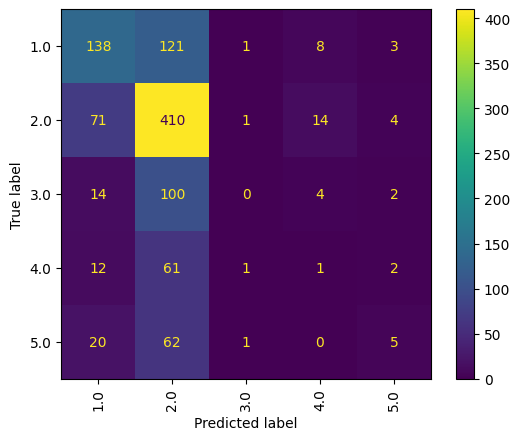

In [ ]:
ConfusionMatrixDisplay.from_predictions(num_countries_ground_truths, pred_num_countries)
plt.xticks(rotation=90)
;

In [ ]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Strongest predictors for class 0

0	gvhd
1	lenalidomide
2	pembrolizumab
3	lymphoma
4	leukemia
5	bevacizumab
6	rituximab
7	trastuzumab
8	stem
9	transplantation
10	pet
11	ctep
12	melanoma
13	tumors
14	nsclc
15	metastatic
16	marrow
17	transplant
18	metastases
19	oncol
20	prostate
21	tho
22	refractory
23	riz
24	paclitaxel
25	measurable
26	dlt
27	nci
28	nivolumab
29	hematologic
30	neutropenia
31	toxicities
32	ecog
33	recist
34	tumor
35	radiation
36	cycles
37	lesions
38	oncology
39	carcinoma
40	hcv
41	solid
42	chemotherapy
43	nodes
44	ctcae
45	lymph
46	reo
47	orr
48	kinase
49	biopsy
50	progressive
51	survival
52	cr
53	xte
54	lesion
55	pfizer
56	advanced
57	registration
58	relapse
59	toxicity
60	cycle
61	bone
62	cancer
63	csf
64	grade
65	expansion
66	cyp
67	molecular
68	evaluable
69	imaging
70	ark
71	diarrhea
72	growth
73	anemia
74	sum
75	recurrent
76	progression
77	scans
78	malignancy
79	scan
80	breast
81	limiting
82	prednisone
83	cd
84	contrast
85	escalation
86	cells
87	ct
88	rash
89	gene
9

779	product
780	receipt
781	assurance
782	sep
783	female
784	reasons
785	distribution
786	list
787	administrative
788	drawn
789	risk
790	dates
791	achieve
792	necessary
793	effective
794	investigators
795	birth
796	male
797	taken
798	temperature
799	total
800	rationale
801	based
802	bleeding
803	general
804	examination
805	number
806	intended
807	meet
808	hiv
809	accurate
810	authorization
811	signature
812	meeting
813	early
814	incidence
815	age
816	maintain
817	assess
818	property
819	direct
820	monitor
821	three
822	adult
823	significant
824	handling
825	involved
826	increases
827	evaluate
828	inc
829	national
830	assessed
831	study
832	dependent
833	standard
834	description
835	supplies
836	full
837	weight
838	consistent
839	system
840	example
841	cardiac
842	important
843	contraceptive
844	www
845	medical
846	examinations
847	assessment
848	virus
849	information
850	would
851	eg
852	currently
853	history
854	significantly
855	entered
856	confirm
857	symptoms
858	per
859	specified


0	covid
1	insulin
2	atezolizumab
3	cognitive
4	randomization
5	sleep
6	unblinded
7	unblinding
8	discharge
9	diabetes
10	dsmb
11	blinded
12	itt
13	compare
14	placebo
15	ingelheim
16	blind
17	randomised
18	block
19	boehringer
20	mortality
21	scores
22	randomized
23	difference
24	alcohol
25	eye
26	hoffmann
27	pubmed
28	influenza
29	edu
30	questionnaire
31	arms
32	project
33	asthma
34	surgery
35	double
36	depression
37	hospital
38	inflammation
39	delivery
40	university
41	prevention
42	recruitment
43	pain
44	vs
45	cardiovascular
46	groups
47	power
48	item
49	department
50	training
51	controlled
52	arm
53	dr
54	kidney
55	participants
56	differences
57	children
58	journal
59	dm
60	score
61	side
62	sided
63	unit
64	pharmacy
65	complications
66	respiratory
67	blinding
68	dmc
69	rating
70	mar
71	team
72	yes
73	disorder
74	alpha
75	glucose
76	injury
77	outcomes
78	inflammatory
79	substance
80	roche
81	asked
82	assignment
83	compared
84	emergency
85	pa
86	www
87	hypothesis
88	experimental
89	grou

789	intensity
790	criterion
791	elevated
792	submitted
793	unexpected
794	safety
795	completion
796	release
797	appropriate
798	occurrence
799	terms
800	hypersensitivity
801	objective
802	findings
803	true
804	product
805	systemic
806	july
807	line
808	requirement
809	dexamethasone
810	laboratory
811	pe
812	november
813	healthy
814	objectives
815	recording
816	adult
817	example
818	administered
819	ecrf
820	upon
821	discontinuation
822	multiple
823	receptor
824	th
825	examination
826	signs
827	confirmed
828	lab
829	pulse
830	therapy
831	solution
832	relationship
833	added
834	open
835	urine
836	exploratory
837	twice
838	ec
839	every
840	suspected
841	received
842	later
843	area
844	unable
845	negative
846	followed
847	manner
848	rationale
849	caused
850	resulting
851	confidence
852	dispensing
853	prophylaxis
854	substantial
855	assessments
856	accordance
857	genetic
858	investigational
859	outside
860	section
861	copy
862	considerations
863	ab
864	law
865	definition
866	detailed
867	sa

0	xte
1	ark
2	reo
3	medi
4	riz
5	merc
6	tho
7	nly
8	ial
9	tak
10	hoffmann
11	ari
12	ro
13	tb
14	lica
15	jec
16	eti
17	roche
18	gs
19	prop
20	ble
21	pli
22	ion
23	pp
24	imp
25	ap
26	ly
27	cu
28	ltd
29	unblinded
30	ub
31	unblinding
32	ert
33	ort
34	arms
35	rescue
36	cs
37	dmc
38	pri
39	ys
40	clean
41	trastuzumab
42	run
43	ri
44	sit
45	novartis
46	gsk
47	ers
48	cli
49	sap
50	ntr
51	blind
52	morning
53	om
54	ny
55	ak
56	mc
57	itt
58	monotherapy
59	fi
60	eye
61	rating
62	influenza
63	substance
64	eri
65	ecrfs
66	sciences
67	eli
68	topical
69	af
70	tio
71	placebo
72	ip
73	atezolizumab
74	blinded
75	ecgs
76	ati
77	randomization
78	esti
79	country
80	nts
81	cns
82	pharmaceuticals
83	unscheduled
84	pharmacodynamic
85	randomised
86	amended
87	cci
88	double
89	immunogenicity
90	visual
91	apr
92	therapeutics
93	aug
94	diary
95	block
96	ad
97	nti
98	inc
99	extension
100	item
101	blinding
102	insulin
103	june
104	im
105	tablet
106	score
107	injections
108	arm
109	vaccination
110	cohorts
111	art
112	

795	adult
796	ei
797	decision
798	adequate
799	record
800	regardless
801	measurement
802	ae
803	must
804	previous
805	person
806	time
807	determined
808	oral
809	members
810	existing
811	presence
812	prior
813	hi
814	inclusion
815	genetic
816	compared
817	sodium
818	discontinue
819	might
820	confidentiality
821	ar
822	indication
823	major
824	approach
825	eudract
826	removed
827	head
828	pre
829	protection
830	continue
831	weight
832	number
833	following
834	includes
835	requires
836	better
837	twice
838	kg
839	age
840	models
841	dependent
842	appendix
843	early
844	ef
845	observed
846	illness
847	rationale
848	database
849	chart
850	documents
851	either
852	upper
853	times
854	hours
855	maximum
856	check
857	systemic
858	pressure
859	file
860	currently
861	ast
862	publication
863	weeks
864	board
865	discretion
866	function
867	safe
868	effect
869	both
870	information
871	worsening
872	call
873	could
874	cannot
875	acid
876	effective
877	prolongation
878	meeting
879	sent
880	descriptio

1484	tumors
1485	metastatic
1486	ctep
1487	recurrence
1488	pcr
1489	transplant
1490	gvhd
1491	pubmed
1492	transplantation
1493	lenalidomide
1494	melanoma
1495	edu
1496	pf
1497	pembrolizumab
1498	covid
1499	bevacizumab
Strongest predictors for class 3

0	medi
1	ass
2	esti
3	nts
4	ess
5	nti
6	oi
7	pri
8	ly
9	tak
10	oll
11	ntr
12	cli
13	cts
14	gsk
15	eli
16	ert
17	ort
18	eri
19	prop
20	cti
21	ers
22	jec
23	pf
24	sit
25	fi
26	ur
27	ati
28	wit
29	ys
30	ub
31	ble
32	lica
33	ol
34	gs
35	xte
36	merc
37	io
38	ni
39	ark
40	nly
41	tio
42	eti
43	ot
44	tb
45	ei
46	cci
47	ari
48	ial
49	mc
50	qd
51	pl
52	cohorts
53	ef
54	nt
55	pli
56	vaccination
57	ul
58	bj
59	fr
60	su
61	pfizer
62	bl
63	unblinded
64	bms
65	immunogenicity
66	qt
67	trastuzumab
68	rescue
69	si
70	vaccines
71	im
72	tablet
73	ut
74	xi
75	imp
76	di
77	vi
78	dm
79	sleep
80	ecgs
81	vaccine
82	hi
83	cmax
84	unblinding
85	ti
86	ad
87	dlt
88	pe
89	tr
90	el
91	wi
92	mi
93	om
94	ri
95	er
96	ic
97	reo
98	periods
99	ps
100	ns
101	cohort
102	ak
103

825	includes
826	concurrent
827	scale
828	functional
829	accordance
830	early
831	investigational
832	partial
833	hormone
834	population
835	possibly
836	significantly
837	emergency
838	work
839	size
840	chronic
841	taken
842	kept
843	discontinued
844	full
845	regulations
846	since
847	subject
848	assess
849	withdrawal
850	recruitment
851	retention
852	combination
853	participate
854	even
855	basis
856	worsening
857	undergo
858	underlying
859	condition
860	jan
861	ab
862	statistical
863	hypersensitivity
864	withdraw
865	material
866	day
867	lab
868	later
869	found
870	effects
871	visits
872	plasma
873	continue
874	although
875	lower
876	cannot
877	markers
878	enrolled
879	caused
880	relationship
881	dna
882	feb
883	list
884	rash
885	55
886	made
887	regarding
888	similar
889	ability
890	dose
891	exclusion
892	true
893	daily
894	procedure
895	provided
896	definition
897	take
898	multicenter
899	discontinuation
900	immediately
901	injection
902	references
903	result
904	develop
905	presen

1483	leukemia
1484	survival
1485	pubmed
1486	metastases
1487	chemotherapy
1488	nci
1489	nivolumab
1490	pfs
1491	breast
1492	metastatic
1493	transplant
1494	novartis
1495	bevacizumab
1496	ctep
1497	lenalidomide
1498	prostate
1499	pembrolizumab
Strongest predictors for class 4

0	tak
1	jec
2	lica
3	prop
4	merc
5	ble
6	medi
7	nly
8	ial
9	xte
10	ark
11	ub
12	ert
13	gs
14	pf
15	gsk
16	cohorts
17	vaccination
18	expansion
19	ers
20	cci
21	ingelheim
22	boehringer
23	riz
24	tho
25	reo
26	qd
27	vaccine
28	ro
29	dlt
30	pfizer
31	mk
32	immunogenicity
33	hoffmann
34	cts
35	influenza
36	novartis
37	ak
38	vaccines
39	clean
40	escalation
41	unblinded
42	cohort
43	om
44	tio
45	pli
46	ly
47	ass
48	qtc
49	roche
50	ecgs
51	esti
52	cmax
53	ort
54	auc
55	ion
56	bms
57	im
58	ys
59	feb
60	ap
61	pk
62	tb
63	pharmacodynamic
64	io
65	cu
66	ari
67	qt
68	sciences
69	eti
70	unblinding
71	bi
72	oll
73	rescue
74	xi
75	mc
76	ppd
77	oi
78	part
79	eli
80	nf
81	eot
82	pp
83	sit
84	jun
85	healthy
86	ad
87	hbv
88	periods
8

829	first
830	developed
831	purpose
832	physical
833	dl
834	specimens
835	original
836	continuous
837	database
838	previous
839	sep
840	considered
841	csf
842	assessment
843	testing
844	continue
845	second
846	threatening
847	liver
848	included
849	cases
850	mar
851	nodes
852	another
853	inhibitor
854	unable
855	occurs
856	signature
857	family
858	stable
859	melanoma
860	recommended
861	activation
862	necessary
863	illness
864	95%
865	recorded
866	completed
867	human
868	assessed
869	dosage
870	indicate
871	results
872	impairment
873	history
874	established
875	result
876	action
877	requires
878	differences
879	prior
880	limited
881	united
882	perform
883	either
884	excluded
885	disability
886	reaction
887	following
888	hepatic
889	methods
890	considerations
891	description
892	withdraw
893	social
894	95
895	analysis
896	good
897	gastrointestinal
898	page
899	time
900	participant
901	state
902	adequate
903	involving
904	positive
905	exam
906	device
907	change
908	june
909	pro
910	persi